## This code produces a PDF of a given scatter plot for visualisation purposes

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, to_rgb
import xarray as xr
from sklearn.neighbors import KernelDensity

In [4]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35751,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:33599,Total threads: 4
Dashboard: /proxy/36057/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:37665,


In [32]:
## Load data
u_along_20deg_unweighted = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/u_along_da_months_20degBins.nc')
CSHT_20deg_unweighted = xr.open_mfdataset('/g/data/hh5/tmp/access-om/fbd581/ASC_project/statisctic_lonbin/CSHT_layerwise_20degBins.nc').isel(depth=slice(None,50))
## For some reason, CSHT has depth levels in meters, and 75 levels, while u_along has 50 levels between 0 and 1. 
## I'm assuming the U_along has just been cut off but the depth levels are the same as CSHT? 
## We don't have the weighting either here, nor do we remove the first X years of the IAF to avoid spin-up periods.


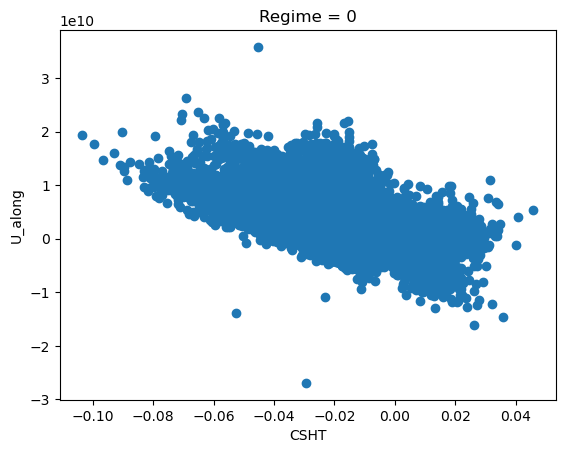

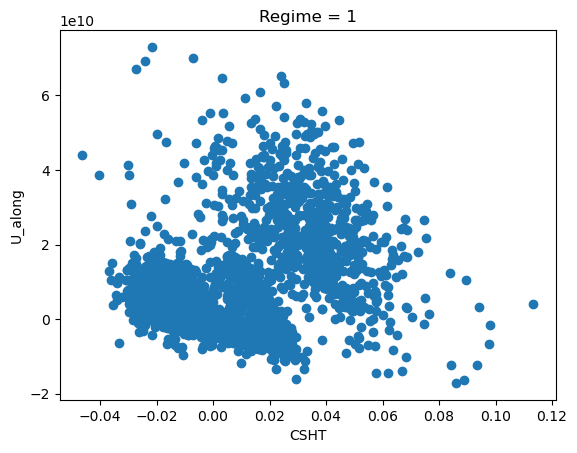

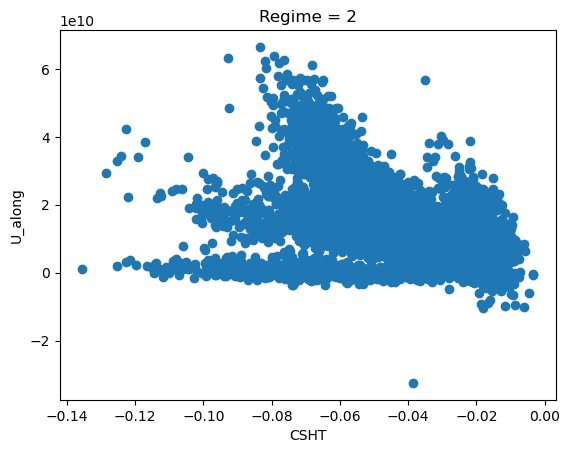

In [90]:
## Here we plot the scatter plots just to check everything makes sense

# First, take the 400-1000m slice and depth-average (NOTE: the layer thickness dz weighting is not used here and needs to be incorporated)
CSHT_sliced = CSHT_20deg_unweighted.isel(depth=slice(37,None)).mean('depth').stack(z=['lon_bins','time'])
U_along_sliced = u_along_20deg_unweighted.isel(depth=slice(37,None)).mean('depth').stack(z=['lon_bins','time'])

## This is only for monthly data - not the climatology, daily, annual!
for i in range(U_along_sliced.regimes.size):
    plt.scatter(U_along_sliced.u_along_da_months_binned.isel(regimes=i),\
                CSHT_sliced.CSHT_layerwise_binned.isel(regimes=i))
    plt.title('Regime = '+str(i))
    plt.xlabel('CSHT')
    plt.ylabel('U_along')
    plt.show()

In [86]:
%%time
## Now, we use Kernel Density Estimation to turn the scatter plots to PDFs! 
## We need to divide by standard deviation to avoid skewed Gaussians being fit onto the scatter plot.
## We also need to remove all NaNs for the KDE to work. 
## We will multiply by STD in the plotting part :)

# Initialize variables
x_grid = np.zeros((3,500,500))
y_grid = np.zeros((3,500,500))
pdf_gauss = np.zeros((3,500,500))

for i in range(U_along_sliced.regimes.size):
    y,x = CSHT_sliced.CSHT_layerwise_binned.isel(regimes=i).dropna(dim='z',how='all')\
    /np.std(CSHT_sliced.CSHT_layerwise_binned.isel(regimes=i).dropna(dim='z',how='all')),\
    U_along_sliced.u_along_da_months_binned.isel(regimes=i).dropna(dim='z',how='all')\
    /np.std(U_along_sliced.u_along_da_months_binned.isel(regimes=i).dropna(dim='z',how='all'))

    # Create a grid to evaluate the PDF
    YY = np.linspace(np.min(y), np.max(y), 500)
    XX = np.linspace(np.min(x), np.max(x), 500)

    x_grid[i,:,:], y_grid[i,:,:] = np.meshgrid(XX, YY)
    grid_points = np.c_[x_grid[i,:,:].ravel(), y_grid[i,:,:].ravel()]
    # Create KDE object
    kde_gauss = KernelDensity(bandwidth=.05, kernel='gaussian')
    # Stack x and y values vertically
    combo_results = np.column_stack([x, y])
    # Fit KDE to the data
    kde_gauss.fit(combo_results)
    # Compute the log density evaluations for each point in the grid
    log_pdf = kde_gauss.score_samples(grid_points)
    
    # Reshape log density evaluations to match the shape of the grid
    pdf_gauss[i,:,:] = np.exp(log_pdf).reshape(x_grid[i,:,:].shape)

0
0
0
0
0
0
1
1
1
1
1
1
2
2
2
2
2
2


In [91]:
def generate_opacity_colormap(color, alpha_values):
    """
    Generate a custom colormap with varying opacity for a given color.

    Parameters:
        color (tuple): RGB values of the color.
        alpha_values (list): List of alpha values, ranging from 0 (fully transparent) to 1 (fully opaque).

    Returns:
        LinearSegmentedColormap: Custom colormap.
    """
    n = len(alpha_values)
    colors = [(*color, alpha) for alpha in alpha_values]
    positions = np.linspace(0, 1, n)
    return LinearSegmentedColormap.from_list("custom_colormap", list(zip(positions, colors)))

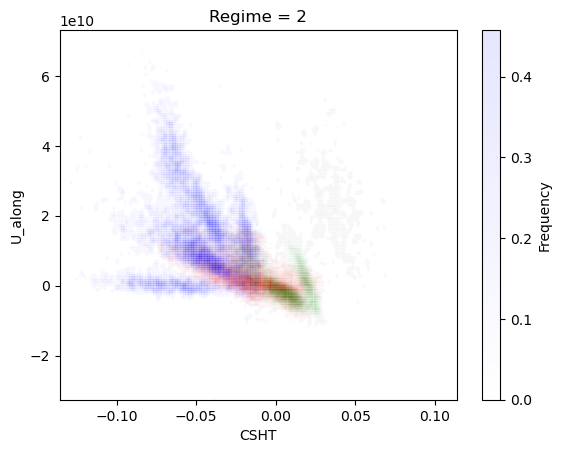

In [104]:
## Define the min, max alphas - modify this if the distributions overlap significantly
min_alpha, max_alpha = 0, 0.1
# Define the colors
base_color = to_rgb('red')
base_color2 = to_rgb('green')
base_color3 = to_rgb('blue')

alpha_values = np.linspace(min_alpha, max_alpha, 256)  # Varying alpha values

# Generate the custom colormap
custom_cmap = generate_opacity_colormap(base_color, alpha_values)
custom_cmap2 = generate_opacity_colormap(base_color2, alpha_values)
custom_cmap3 = generate_opacity_colormap(base_color3, alpha_values)
cmaps = [custom_cmap,custom_cmap2,custom_cmap3]

# Plot the KDEs with a transparent colorbar
for i in range(U_along_sliced.regimes.size):
    plt.pcolor(x_grid[i,:,:]*np.std(U_along_sliced.u_along_da_months_binned.isel(regimes=i).dropna(dim='z',how='all')).values, \
           y_grid[i,:,:]*np.std(CSHT_sliced.CSHT_layerwise_binned.isel(regimes=i).dropna(dim='z',how='all')).values,\
           pdf_gauss[i,:,:],cmap=cmaps[i],linewidth=0,rasterized=True)
plt.title('Regime = '+str(i))
plt.colorbar(label='Frequency')
plt.xlabel('CSHT')
plt.ylabel('U_along')
plt.savefig('/g/data/e14/txs156/Figures/ASC_KDE_example_contourplot.png', dpi=300, bbox_inches='tight')
plt.show()